# Random Forest = Validation & Confidence (proves that we didn't leave performance on the table)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_score, recall_score, f1_score, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

# Drop multicollinearity features
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)
df = df.drop(['duration'], axis=1)

# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})
print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le

print(f"\nCategorical columns encoded: {len(categorical_cols)}")

# Train-Test Split (NO scaling needed for Tree)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Dataset shape: (41176, 17)
Target distribution: {0: 36537, 1: 4639}

Categorical columns encoded: 10

Train set size: 32940
Test set size: 8236


In [5]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=10,            # Limit depth to reduce overfitting
    min_samples_split=50,    # Minimum samples to split node
    min_samples_leaf=20,     # Minimum samples in leaf node
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1,               # Use all CPU cores for training
    verbose=0
)

print("Training Random Forest with parameters:")
print(f"  - Trees: {rf_classifier.n_estimators}")
print(f"  - Max depth: {rf_classifier.max_depth}")
print(f"  - Min samples split: {rf_classifier.min_samples_split}")
print(f"  - Min samples leaf: {rf_classifier.min_samples_leaf}")
print(f"  - Class weight: {rf_classifier.class_weight}")
print("\nTraining in progress...")

rf_classifier.fit(X_train, y_train)
print("✓ Random Forest trained successfully!")

Training Random Forest with parameters:
  - Trees: 100
  - Max depth: 10
  - Min samples split: 50
  - Min samples leaf: 20
  - Class weight: balanced

Training in progress...
✓ Random Forest trained successfully!


In [6]:
print("\nGenerating predictions...")

# Training set predictions
y_train_pred = rf_classifier.predict(X_train)
y_train_pred_proba = rf_classifier.predict_proba(X_train)[:, 1]

# Test set predictions
y_test_pred = rf_classifier.predict(X_test)
y_test_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

print("✓ Predictions generated for train and test sets")



Generating predictions...
✓ Predictions generated for train and test sets


In [7]:
print("TRAINING SET PERFORMANCE")
print(f"{'='*70}")
print(f"Accuracy:  {(y_train_pred == y_train).mean():.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_pred_proba):.4f}")

TRAINING SET PERFORMANCE
Accuracy:  0.8550
Precision: 0.4073
Recall:    0.6308
F1-Score:  0.4950
ROC-AUC:   0.8462


In [8]:
print("TEST SET PERFORMANCE (PRIMARY EVALUATION)")
print(f"{'='*70}")

accuracy_test = (y_test_pred == y_test).mean()
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f"Accuracy:  {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")
print(f"ROC-AUC:   {roc_auc_test:.4f}")

print(f"\n{'Classification Report (Test Set)':}")
print(classification_report(y_test, y_test_pred, 
                          target_names=['No Conversion', 'Conversion'],
                          digits=4))

TEST SET PERFORMANCE (PRIMARY EVALUATION)
Accuracy:  0.8570
Precision: 0.4133
Recall:    0.6422
F1-Score:  0.5030
ROC-AUC:   0.8149

Classification Report (Test Set)
               precision    recall  f1-score   support

No Conversion     0.9511    0.8842    0.9165      7308
   Conversion     0.4133    0.6422    0.5030       928

     accuracy                         0.8570      8236
    macro avg     0.6822    0.7632    0.7097      8236
 weighted avg     0.8905    0.8570    0.8699      8236



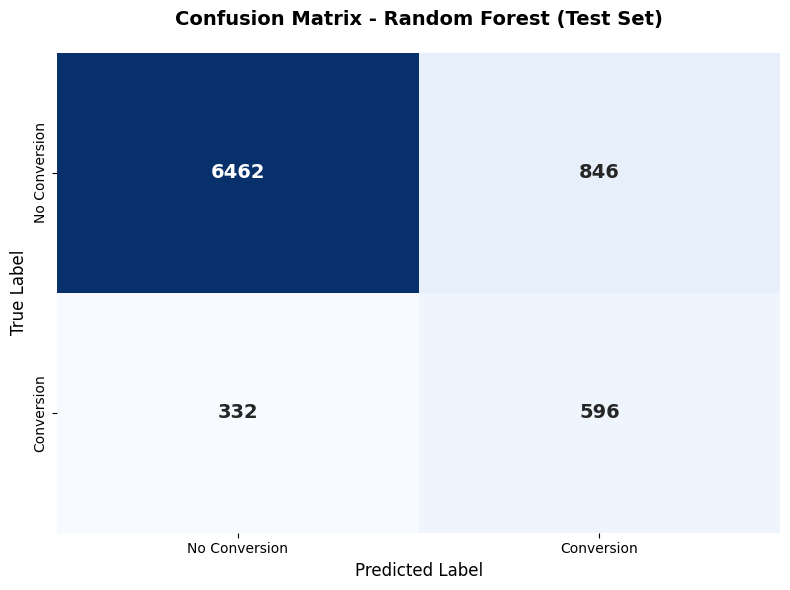


Confusion Matrix Breakdown:
  True Negatives:  6,462
  False Positives: 846
  False Negatives: 332
  True Positives:  596


In [9]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix - Random Forest (Test Set)', 
          fontweight='bold', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

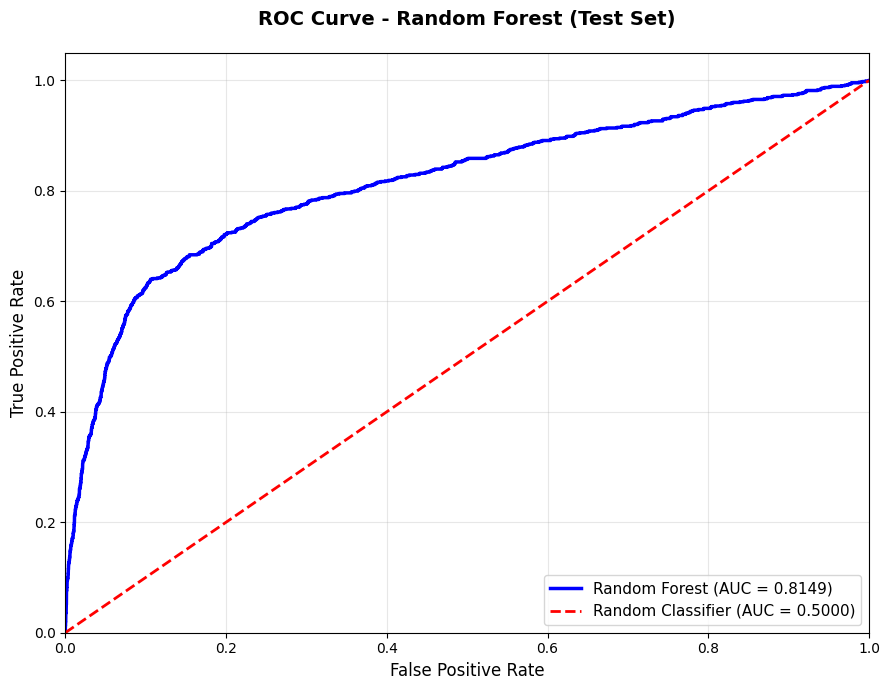

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, color='blue', lw=2.5, 
         label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest (Test Set)', 
          fontweight='bold', fontsize=14, pad=20)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
feature_names = X_encoded.columns.tolist()
feature_importance = rf_classifier.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\n{'='*70}")
print("FEATURE IMPORTANCE RANKINGS")
print(f"{'='*70}")
print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

print(f"\nTop 5 Features Account for: {importance_df.head(5)['Importance'].sum()*100:.2f}% of total importance")



FEATURE IMPORTANCE RANKINGS

Top 15 Most Important Features:
       Feature  Importance
     euribor3m    0.382874
 cons.conf.idx    0.123465
cons.price.idx    0.080895
         pdays    0.074406
      poutcome    0.070676
         month    0.059260
           age    0.043910
      previous    0.032168
       contact    0.030273
      campaign    0.021221
   day_of_week    0.017805
     education    0.017409
           job    0.016280
       default    0.010297
       marital    0.008053

Top 5 Features Account for: 73.23% of total importance


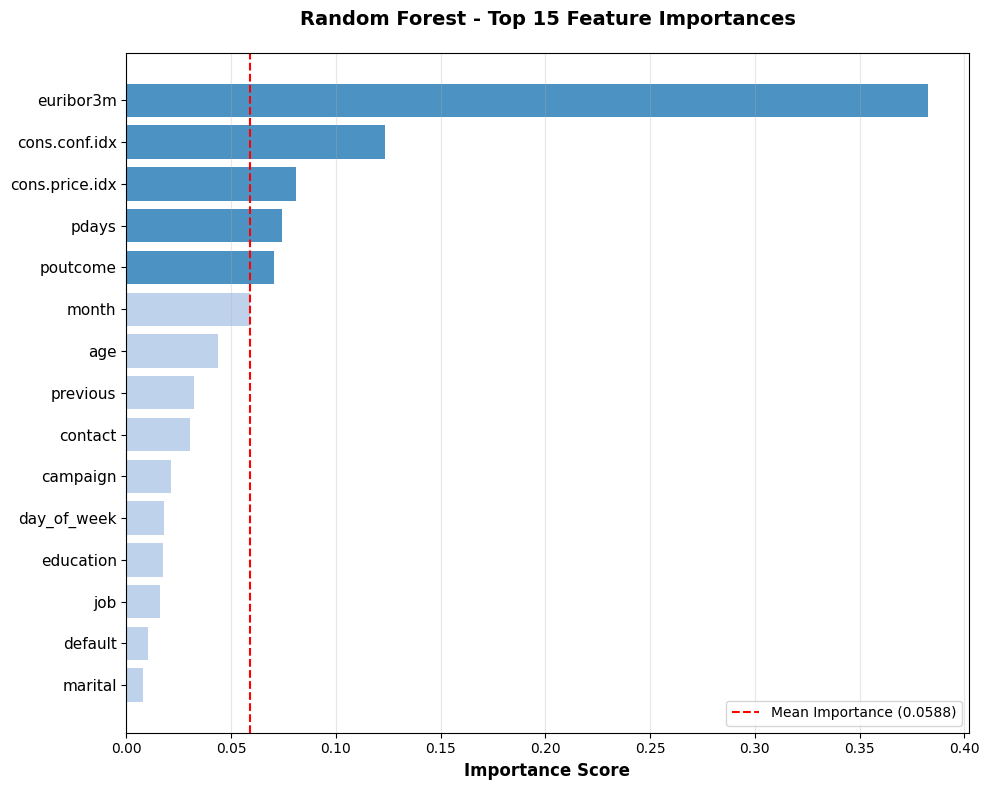

In [12]:
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
colors = ['#1f77b4' if i < 5 else '#aec7e8' for i in range(top_n)]
plt.barh(range(top_n), top_features['Importance'], color=colors, alpha=0.8)
plt.yticks(range(top_n), top_features['Feature'], fontsize=11)
plt.gca().invert_yaxis()
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Random Forest - Top 15 Feature Importances', 
          fontweight='bold', fontsize=14, pad=20)
plt.axvline(x=importance_df['Importance'].mean(), 
            color='red', linestyle='--', linewidth=1.5, 
            label=f'Mean Importance ({importance_df["Importance"].mean():.4f})')
plt.legend(fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()